In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import math
import os

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 4)

# Read Data

In [2]:
# get file directory 
current_directory = os.path.dirname(os.path.abspath('main.ipynb'))
file_path = os.path.join(current_directory, "monatszahlen2501_verkehrsunfaelle_27_02_25.csv") 

In [3]:
# read the existing subset of the data
raw_df =  pd.read_csv(file_path, encoding='utf-8')

# Translate Headers 
col_map = {
        'MONATSZAHL':                  'Category',
        'AUSPRAEGUNG':                  'Accident_type',
        'JAHR':                         'Year',
        'MONAT':                        'Month',
        'WERT':                         'Value',
        'VORJAHRESWERT':                'PreviousYearValue',
        'VERAEND_VORMONAT_PROZENT':     'ChangeFromPreviousMonth',
        'VERAEND_VORJAHRESMONAT_PROZENT':'ChangeFromSameMonthLastYear',
        'ZWOELF_MONATE_MITTELWERT':      'Year_Avg',
    }

df = raw_df.rename(columns=col_map)

# save backup
backup = df.copy()

In [4]:
df.head().T

,0,1,2,3,4
Category,Alkoholunfälle,Alkoholunfälle,Alkoholunfälle,Alkoholunfälle,Alkoholunfälle
Accident_type,insgesamt,insgesamt,insgesamt,insgesamt,insgesamt
Year,2024,2024,2024,2024,2024
Month,202401,202402,202403,202404,202405
Value,NaN,NaN,NaN,NaN,NaN
PreviousYearValue,NaN,NaN,NaN,NaN,NaN
ChangeFromPreviousMonth,NaN,NaN,NaN,NaN,NaN
ChangeFromSameMonthLastYear,NaN,NaN,NaN,NaN,NaN
Year_Avg,NaN,NaN,NaN,NaN,NaN


# data cleansing and pre-processing

In [5]:
df = df[df['Value'].notna()] # we need no nan values in the target column

In [6]:
# Month column >> datetime format
df['Month'] = pd.to_datetime(df['Month'].astype(str), format="%Y%m", errors='coerce') # 'coerce' removes "Summe" values and replases Nan 
df['Month'] = df['Month'].dt.to_period('m')
df = df[df['Month'].notna()]

In [7]:
df['month_num'] = df['Month'].dt.month

In [8]:
# cyclic encoding for seasonality
df['sin_month'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month_num'] / 12)

In [9]:
# add season column
def season(m):
    if m in (12,1,2): return 'Winter'
    if m in (3,4,5):  return 'Spring'
    if m in (6,7,8):  return 'Summer'
    return 'Autumn'
df['Season'] = df['month_num'].apply(season)

In [10]:
df.head().T

,25,26,27,28,29
Category,Alkoholunfälle,Alkoholunfälle,Alkoholunfälle,Alkoholunfälle,Alkoholunfälle
Accident_type,insgesamt,insgesamt,insgesamt,insgesamt,insgesamt
Year,2022,2022,2022,2022,2022
Month,2022-01,2022-02,2022-03,2022-04,2022-05
Value,19.0,32.0,28.0,34.0,57.0
PreviousYearValue,16.0,14.0,24.0,16.0,24.0
ChangeFromPreviousMonth,-9.52,68.42,-12.5,21.43,67.65
ChangeFromSameMonthLastYear,18.75,128.57,16.67,112.5,137.5
Year_Avg,32.0,34.0,34.0,36.0,38.0
month_num,1,2,3,4,5


In [11]:
# categorical columns
df['Accident_type'] = df['Accident_type'].astype('category')
df['Category'] = df['Category'].astype('category')

In [12]:
# translate the Category and Accident_type columna to English
metric_trs = {
    "Alkoholunfälle":     "Alcohol",
    "Fluchtunfälle":      "Hit-and-run",
    "Verkehrsunfälle":    "Traffic",
}
Accident_type_trs = {
    "insgesamt":                   "Total",
    "Verletzte und Getötete":      "Injuries and fatalities",
    "mit Personenschäden":         "With personal injuries",
}

df['Category'] = df['Category'].replace(metric_trs)
df['Accident_type'] = df['Accident_type'].replace(Accident_type_trs)

In [13]:
""" Create the 1-month and 2_month lage features """
df = (
    df
    .sort_values(['Category','Accident_type','Month'])
    .groupby(['Category','Accident_type'])
    .apply(lambda g: g.assign(
        lag_1 = g['Value'].shift(1),
        lag_2 = g['Value'].shift(2)
    ))
    .reset_index(drop=True)
)

In [14]:
# remove any data that comes after 2020
df_removed = df[df['Year'] > 2020] # we'll use this later to measure the pred acc
df = df[df['Year'] <= 2020] 
df['Year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
      dtype=int64)

In [15]:
df = df.set_index('Month')
df.head().T

Month,2000-01,2000-02,2000-03,2000-04,2000-05
Category,Alcohol,Alcohol,Alcohol,Alcohol,Alcohol
Accident_type,Injuries and fatalities,Injuries and fatalities,Injuries and fatalities,Injuries and fatalities,Injuries and fatalities
Year,2000,2000,2000,2000,2000
Value,37.0,19.0,18.0,26.0,44.0
PreviousYearValue,NaN,NaN,NaN,NaN,NaN
ChangeFromPreviousMonth,NaN,-48.65,-5.26,44.44,69.23
ChangeFromSameMonthLastYear,NaN,NaN,NaN,NaN,NaN
Year_Avg,37.0,28.0,25.0,25.0,29.0
month_num,1,2,3,4,5
sin_month,0.5,0.866025,1.0,0.866025,0.5


# Visualization: Monthly Accident Trends by Category

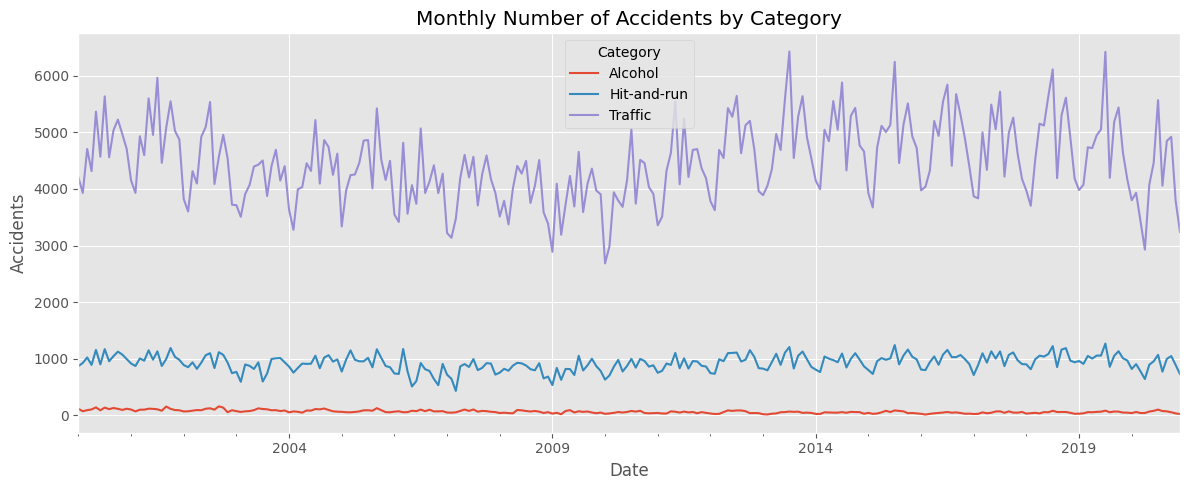

In [16]:
""" monthly time series  """
# pivot 
acc_by_cat = df.pivot_table(values='Value',
                            index=df.index,
                            columns='Category',
                            aggfunc='sum')
# plot
ax = acc_by_cat.plot(figsize=(12,5))
ax.set_title("Monthly Number of Accidents by Category")
ax.set_ylabel("Accidents")
ax.set_xlabel("Date")
plt.legend(title="Category")
plt.tight_layout()

In [17]:
# data to plot
df_ts = df.copy()
df_ts.index = df_ts.index.to_timestamp() 
df_vis = df_ts.reset_index() 

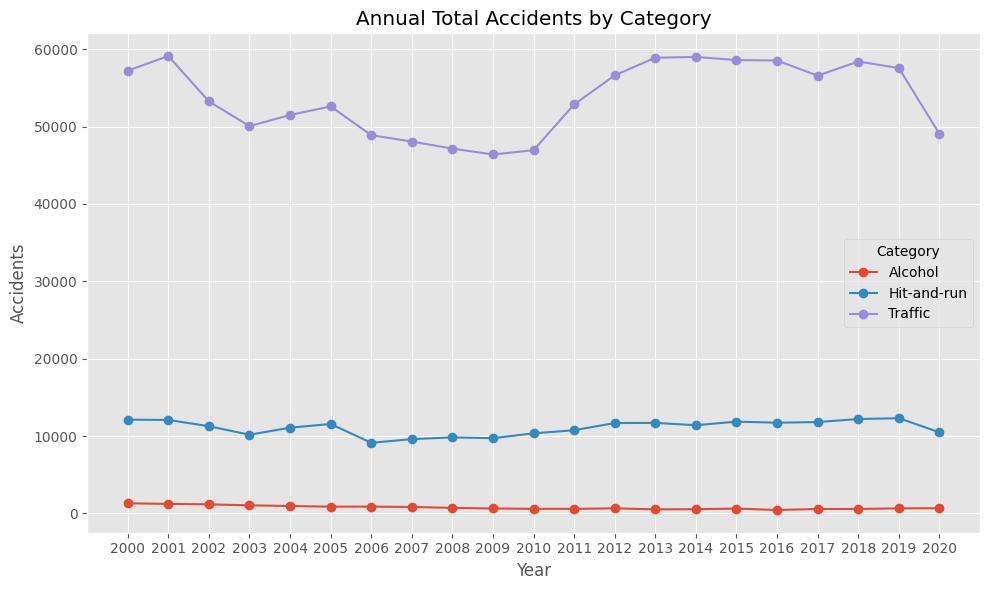

In [18]:
""" yearly totals""" 
yearly = (
    df_vis
    .groupby([df_vis['Month'].dt.year, 'Category'])['Value']
    .sum()
    .unstack(fill_value=0)
)

plt.figure(figsize=(10, 6))
for cat in yearly.columns:
    plt.plot(yearly.index, yearly[cat], marker='o', label=cat)

plt.title("Annual Total Accidents by Category")
plt.xlabel("Year")
plt.ylabel("Accidents")
plt.legend(title="Category")
plt.xticks(yearly.index)  # keep integer years
plt.tight_layout()

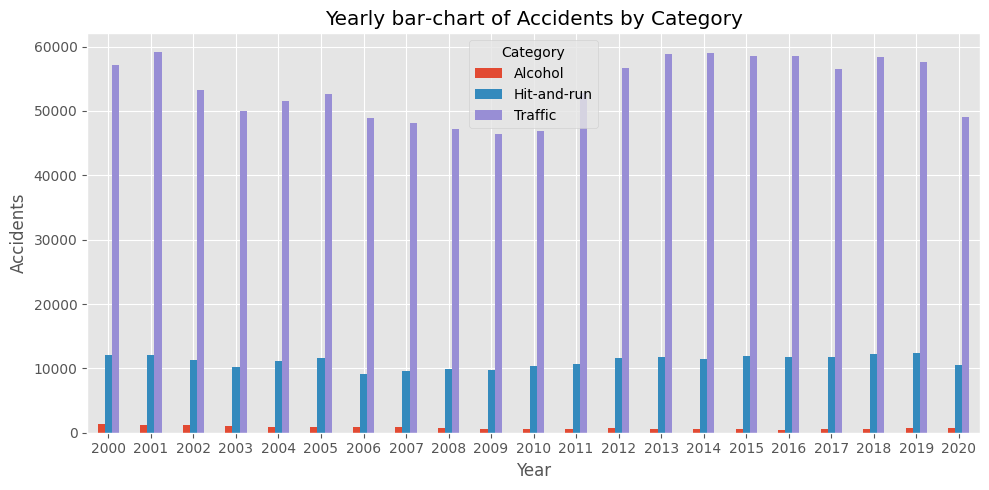

In [19]:
""" annual bars """
yearly = df_vis.reset_index().groupby([df_vis['Year'], 'Category'])['Value'].sum().unstack()

yearly.plot(kind='bar', figsize=(10,5))
plt.title("Yearly bar‐chart of Accidents by Category")
plt.ylabel("Accidents")
plt.xlabel("Year")
plt.xticks(rotation=0)
plt.tight_layout()

c:\Users\zhila\anaconda3\envs\myenv\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\zhila\anaconda3\envs\myenv\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\zhila\anaconda3\envs\myenv\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


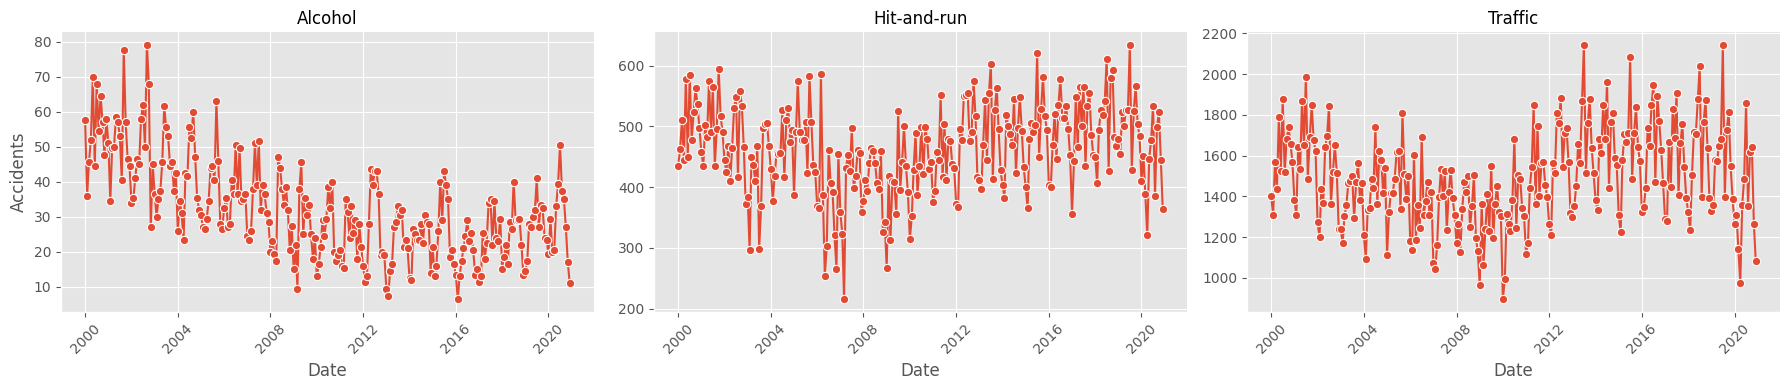

In [20]:
# clean up missing values 
long = df_vis.copy()
long['Value'] = long['Value'].replace([np.inf, -np.inf], np.nan)
long = long.dropna(subset=['Value'])

# xtract only the three columns we need
long = long[['Month','Category','Value']]

# FacetGrid
g = sns.FacetGrid(long, col="Category", col_wrap=3, height=4, aspect=1.5, sharey=False)
g.map_dataframe(sns.lineplot, x="Month", y="Value", marker="o", ci=None)
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)
g.set_axis_labels("Date", "Accidents")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()

# Time-series pipeline

In [21]:
df = df.reset_index()
X = df.drop(columns=['Value'])
y = df['Value']

In [22]:
categorical_cols = ['Category', 'Accident_type', 'Season']
numeric_cols = [
    'Year',
    'Year_Avg',
    'ChangeFromPreviousMonth',
    'ChangeFromSameMonthLastYear',
    'PreviousYearValue',   # 12-month lag
    'lag_1',               # 1-month lag
    'lag_2',               # 2-month lag
    'sin_month', # cyclic month feature
    'cos_month', # cyclic month feature
]


preprocessor = ColumnTransformer([
    # Categorical: one-hot encode
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    # Numerical: first impute, then scale
    ('num', Pipeline([
         ('impute', SimpleImputer(strategy='mean')), 
         ('scale',  StandardScaler()),
     ]), numeric_cols),
], remainder='drop')

In [23]:
""" define model """
model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=3,
                                    validation_fraction=0.05, n_iter_no_change=10, tol=1e-4)

pipeline = Pipeline([
    ('prep', preprocessor),
    ('est', model),
])
pipeline.fit(X, y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Category', 'Accident_type',
                                                   'Season']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Year', 'Year_Avg',
                                                   'ChangeFromPreviousMonth',
                                                   'ChangeFromSameMonthLastYear',
                                                   'PreviousYearValue', 'lag_1',
                                                   'lag_2', 'sin_month',
                                                   'cos_month'])])),
                ('est',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=500,
                                           n_iter_no_change=10,
                                           validation_fraction=0.05))])

#  Evaluation 

In [24]:
""" Prepare hold-out frame (years > 2020) """

df_holdout = df_removed.reset_index(drop=True)
df_holdout = df_holdout[df_holdout['Value'].notna()] # Drop rows where the target is missing

# Split into X/y
X_holdout = df_holdout.drop(columns=['Value'])
y_holdout = df_holdout['Value']

In [25]:
# Make forecasts 
y_pred_holdout = pipeline.predict(X_holdout)

# Compute metrics
mae  = mean_absolute_error(y_holdout, y_pred_holdout)
rmse = mean_squared_error(y_holdout, y_pred_holdout, squared=False)
r2   = r2_score(y_holdout, y_pred_holdout)
mean_val = y_holdout.mean()
normalized_MAE = round((mae / mean_val)*100, 3)
print(f"HOLD-OUT MAE:  {mae:.2f}")
print(f"HOLD-OUT RMSE: {rmse:.2f}")
print(f"HOLD-OUT R²:   {r2:.3f}")
print("MAE / mean:", normalized_MAE, '%')

HOLD-OUT MAE:  30.85
HOLD-OUT RMSE: 63.45
HOLD-OUT R²:   0.997
MAE / mean: 4.218 %


# Prediction 

In [26]:
""" value for 2021-01 """

metric, accident_type = "Alcohol", "Total"
target = pd.Period("2021-01","M")

ground_truth = df_removed.loc[
                (df_removed['Category']==metric) &
                (df_removed['Accident_type']==accident_type) &
                (df_removed['Month']==pd.Period("2021-01","M")),
                'Value'
].iat[0]

#get 2020-01 value
prev_year_val = df.loc[
    (df['Category']==metric) &
    (df['Accident_type']==accident_type) &
    (df['Month']==pd.Period("2020-01","M")),
    'Value'
].iat[0]

year_avg_series = df.loc[
    (df['Category']==metric) &
    (df['Accident_type']==accident_type) &
    (df['Year']==2020),
    'Value'
].mean()

# input for prediction
m = target.month  # 1
sin_m = np.sin(2*np.pi*m/12)   
cos_m = np.cos(2*np.pi*m/12)   

# Compute lags from df
dec_2020 = df.loc[
    (df['Category']==metric) &
    (df['Accident_type']==accident_type) &
    (df['Month']==pd.Period("2020-12","M")),
    'Value'
].iat[0]

nov_2020 = df.loc[
    (df['Category']==metric) &
    (df['Accident_type']==accident_type) &
    (df['Month']==pd.Period("2020-11","M")),
    'Value'
].iat[0]

X_new = pd.DataFrame([{
    'Category':                    metric,
    'Accident_type':               accident_type,
    'Year':                        2021,
    'Month':                       str(target),       
    'PreviousYearValue':           prev_year_val,
    'lag_1':                       dec_2020,           # 1‐month lag
    'lag_2':                       nov_2020,           # 2‐month lag
    'ChangeFromPreviousMonth':     np.nan,             
    'ChangeFromSameMonthLastYear': np.nan,             
    'Year_Avg':                    year_avg_series,
    'month_num':                   m,
    'sin_month':                   sin_m,
    'cos_month':                   cos_m,
    'Season':                      'Winter'
}])

In [27]:
print("Prediction for 2021-01:")
forecast = pipeline.predict(X_new)

print(f" Actual value: {ground_truth:.1f}")
print(f" Calculated forecast: {forecast[0]:.1f}")

Prediction for 2021-01:
 Actual value: 16.0
 Calculated forecast: 10.0


# Export trained pipeline

In [ ]:
import pickle

with open("pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)